# Exploración de datos de la epidemia de Covid19 en México

Casos de estudio reportados por la Secretaria de Salud de pacientes sospechos y confirmados de SARS-Cov2.

Tomados de https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico.

In [1]:
# librerias
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import integrate, linalg, optimize, interpolate, loadtxt
from scipy import pi,array,zeros,eye,special,misc
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(13,8)})

In [2]:
# Catálogos
ruta = os.getcwd()
ENTIDADES = pd.read_csv(os.path.join(ruta, 'data/ENTIDADES.csv'), encoding='latin-1')
MUNICIPIOS = pd.read_csv(os.path.join(ruta, 'data/MUNICIPIO.csv'), encoding='latin-1',)
NACIONALIDAD = pd.read_csv(os.path.join(ruta, 'data/NACIONALIDAD.csv'))
ORIGEN = pd.read_csv(os.path.join(ruta, 'data/ORIGEN.csv'))
RESULTADO = pd.read_csv(os.path.join(ruta, 'data/RESULTADO.csv'))
SECTOR = pd.read_csv(os.path.join(ruta, 'data/SECTOR.csv'))
SEXO = pd.read_csv(os.path.join(ruta, 'data/SEXO.csv'))
SI_NO = pd.read_csv(os.path.join(ruta, 'data/SI_NO.csv'))
TIPO_PACIENTE = pd.read_csv(os.path.join(ruta, 'data/TIPO_PACIENTE.csv'))

In [8]:
# Datos
ruta_data = os.path.join(ruta, 'data/consol_new.csv')
covid19 = pd.read_csv(ruta_data, encoding='latin-1')
covid19['FECHA_ACTUALIZACION'] = pd.to_datetime(covid19['FECHA_ACTUALIZACION'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_INGRESO'] = pd.to_datetime(covid19['FECHA_INGRESO'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_SINTOMAS'] = pd.to_datetime(covid19['FECHA_SINTOMAS'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_DEF'] = pd.to_datetime(covid19['FECHA_DEF'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_DEF_PREV'] = pd.to_datetime(covid19['FECHA_DEF_PREV'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_ACTUALIZACION_PREV'] = pd.to_datetime(covid19['FECHA_ACTUALIZACION_PREV'], format='%Y-%m-%d', errors='coerce')

In [41]:
# Columnas
covid19.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'RESULTADO', 'MIGRANTE', 'PAIS_NACIONALIDAD',
       'PAIS_ORIGEN', 'UCI', 'DIAS_FIS', 'ACTIVO', 'FECHA_ACTUALIZACION_PREV',
       'RESULTADO_PREV', 'FECHA_DEF_PREV', 'TIPO_PACIENTE_PREV',
       'INTUBADO_PREV', 'UCI_PREV', 'index'],
      dtype='object')

In [9]:
# Estadistica descriptiva
covid19.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,UCI,DIAS_FIS,ACTIVO,FECHA_ACTUALIZACION_PREV,RESULTADO_PREV,FECHA_DEF_PREV,TIPO_PACIENTE_PREV,INTUBADO_PREV,UCI_PREV,index
0,2020-04-19,1335b7,1,4,16,2,16,16,53.0,1,...,97,116.0,0.0,2020-04-19,3,NaT,1,97,97,NaN
1,2020-04-19,099520,1,4,5,1,5,5,18.0,2,...,2,92.0,0.0,2020-04-19,1,2020-04-05,2,2,2,NaN
2,2020-04-19,0a271a,2,12,23,1,17,23,5.0,1,...,97,82.0,0.0,2020-04-19,3,NaT,1,97,97,NaN
3,2020-04-19,03edf6,2,12,11,2,11,11,27.0,1,...,97,29.0,0.0,2020-04-19,2,NaT,1,97,97,NaN
4,2020-04-19,179b46,1,4,9,2,99,9,7.0,2,...,2,92.0,0.0,2020-04-19,3,NaT,2,2,2,NaN


In [16]:
covid19.FECHA_ACTUALIZACION.max()

Timestamp('2020-07-07 00:00:00')

In [11]:
resultados = covid19[['ID_REGISTRO', 'FECHA_SINTOMAS', 'RESULTADO']].merge(RESULTADO, left_on='RESULTADO', right_on='CLAVE' )
resultados.drop(['CLAVE', 'RESULTADO'], axis=1, inplace=True)
resultados.rename(columns={'DESC':'RESULTADO'}, inplace=True)
resultados.RESULTADO.astype('category');

In [ ]:
resultados.head()

In [12]:
resultados_pivot = pd.pivot_table(resultados, values='ID_REGISTRO', index=['FECHA_SINTOMAS'], 
                        columns=['RESULTADO'], aggfunc='count', fill_value=0).reset_index()
resultados_pivot.set_index('FECHA_SINTOMAS', inplace=True);

In [13]:
resultados_pivot.POSITIVO.sum()

270248

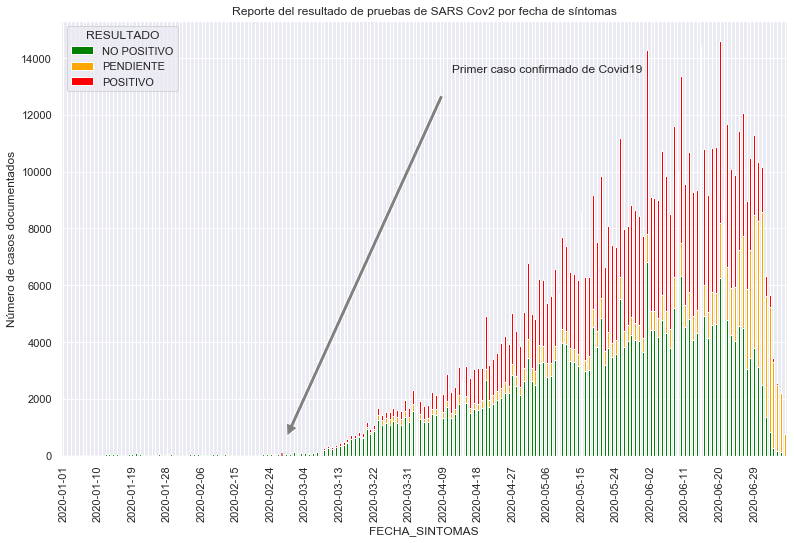

In [14]:
ax0 = resultados_pivot.plot(kind='bar',stacked=True, color=['green', 'orange', 'red'])
ticklabels = ['']*len(resultados_pivot.index)
skip = len(resultados_pivot)//20
ticklabels[::skip] = resultados_pivot.index[::skip].strftime('%Y-%m-%d')
ax0.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
plt.vlines(57, 0, 90, 'r')
ax0.annotate('Primer caso confirmado de Covid19', (56, 10),
            xytext=(0.8, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='grey', shrink=0.05),
            fontsize=12,
            horizontalalignment='right', verticalalignment='top')
ax0.set_ylabel("Número de casos documentados");
ax0.set_title("Reporte del resultado de pruebas de SARS Cov2 por fecha de síntomas");

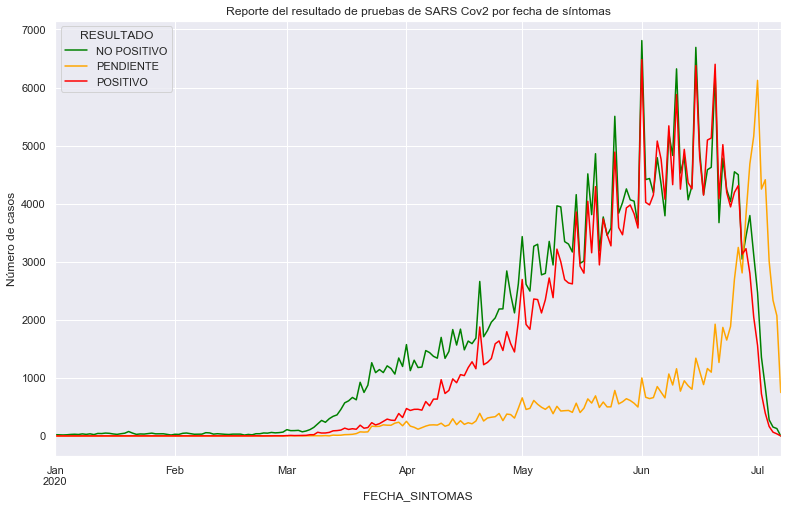

In [15]:
ax1 = resultados_pivot.plot(color=['green', 'orange', 'red'])
ax1.set_ylabel("Número de casos");
ax1.set_title("Reporte del resultado de pruebas de SARS Cov2 por fecha de síntomas");

In [17]:
entidades = covid19[covid19.RESULTADO == 1][['ID_REGISTRO', 'FECHA_SINTOMAS', 'RESULTADO', 'ENTIDAD_NAC']].merge(ENTIDADES, left_on='ENTIDAD_NAC', right_on='CLAVE' )
entidades.drop(['ENTIDAD_NAC', 'CLAVE', 'ABREV'], axis=1, inplace=True)
entidades.columns = ['ID_REGISTRO','FECHA_SINTOMAS','RESULTADO', 'ESTADOS']
entidades.ESTADOS.astype('category');

In [18]:
entidades_pivot = pd.pivot_table(entidades, values='ID_REGISTRO', index=['FECHA_SINTOMAS'], 
                        columns=['ESTADOS'], aggfunc='count', fill_value=0).reset_index()
entidades_pivot.set_index('FECHA_SINTOMAS', inplace=True);

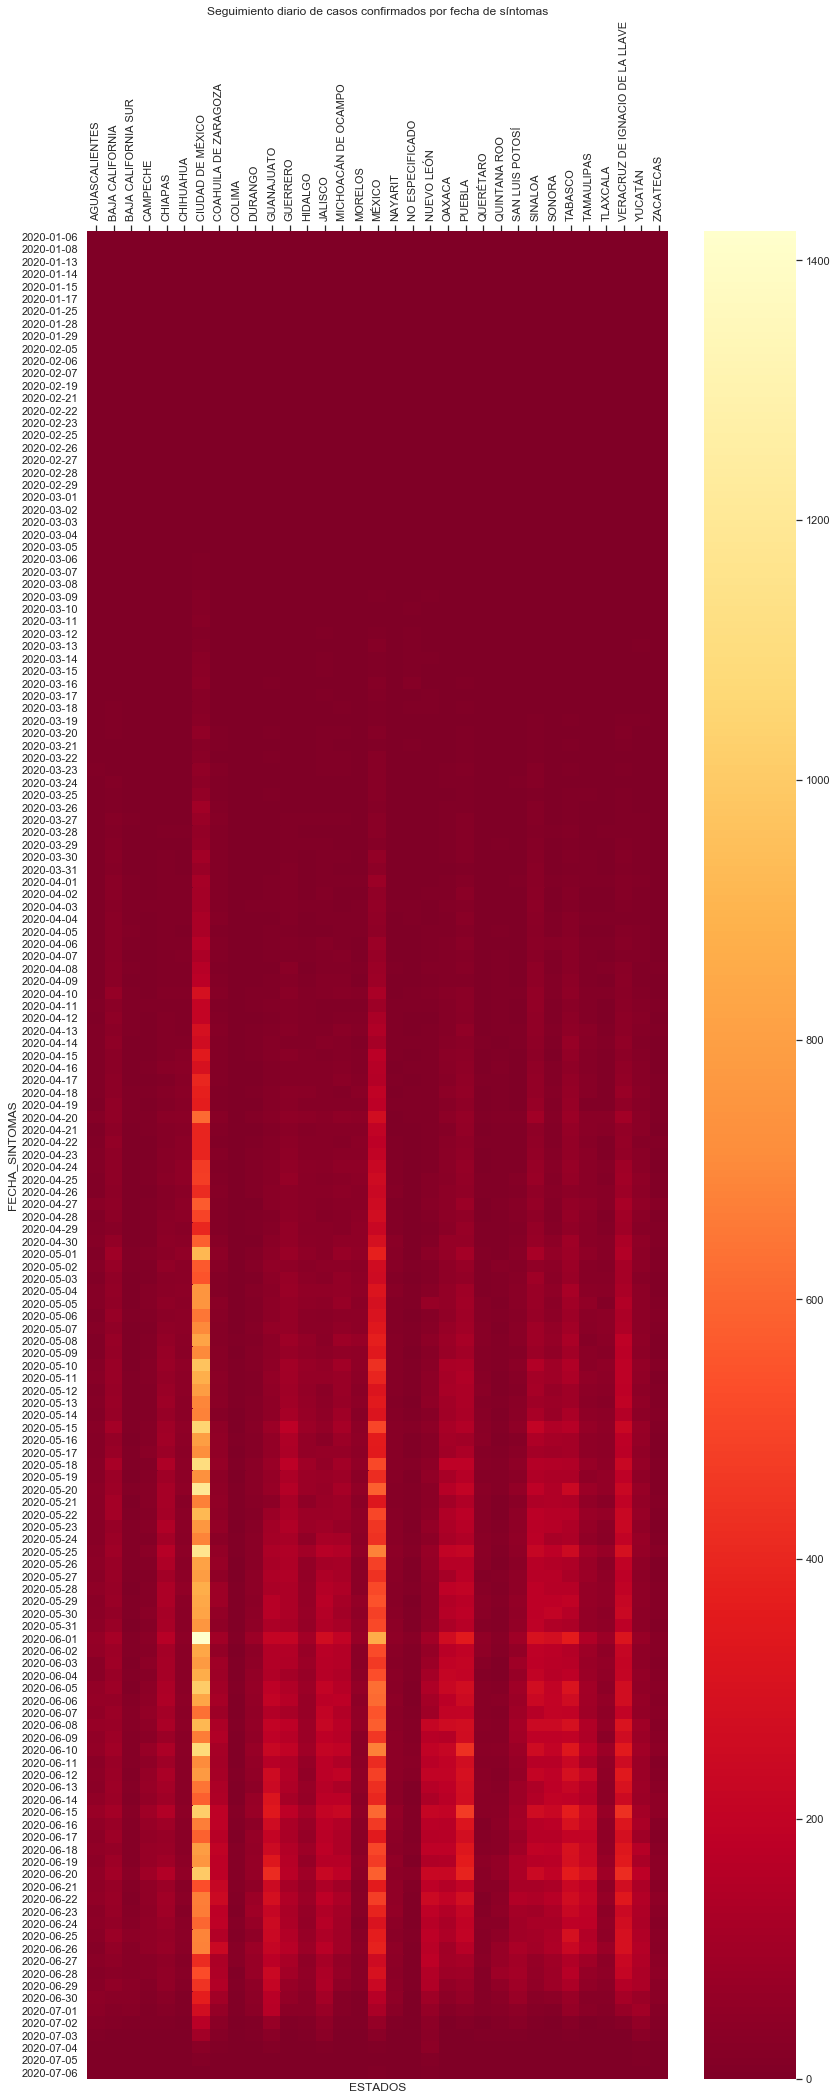

In [43]:
fig, ax = plt.subplots(
        figsize=(13,34))
ax = sns.heatmap(entidades_pivot, cmap='YlOrRd_r', xticklabels=True, yticklabels=True)
ax.set_yticklabels(entidades_pivot.index.strftime('%Y-%m-%d'));
ax.xaxis.set_ticks_position('top');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title("Seguimiento diario de casos confirmados por fecha de síntomas");

### Detalle de casos cuyas prueba de covid19 fue no positiva.

In [20]:
# detalle casos cuyas prueba de covid19 fue no positiva
entidades_np = covid19[covid19.RESULTADO == 2][['ID_REGISTRO', 'FECHA_SINTOMAS', 'RESULTADO', 'ENTIDAD_NAC']].merge(ENTIDADES, left_on='ENTIDAD_NAC', right_on='CLAVE' )
entidades_np.drop(['ENTIDAD_NAC', 'CLAVE', 'ABREV'], axis=1, inplace=True)
entidades_np.columns = ['ID_REGISTRO','FECHA_SINTOMAS','RESULTADO', 'ESTADOS']
entidades_np.ESTADOS.astype('category');

In [21]:
entidades_np_pivot = pd.pivot_table(entidades_np, values='ID_REGISTRO', index=['FECHA_SINTOMAS'], 
                        columns=['ESTADOS'], aggfunc='count', fill_value=0).reset_index()
entidades_np_pivot.set_index('FECHA_SINTOMAS', inplace=True);

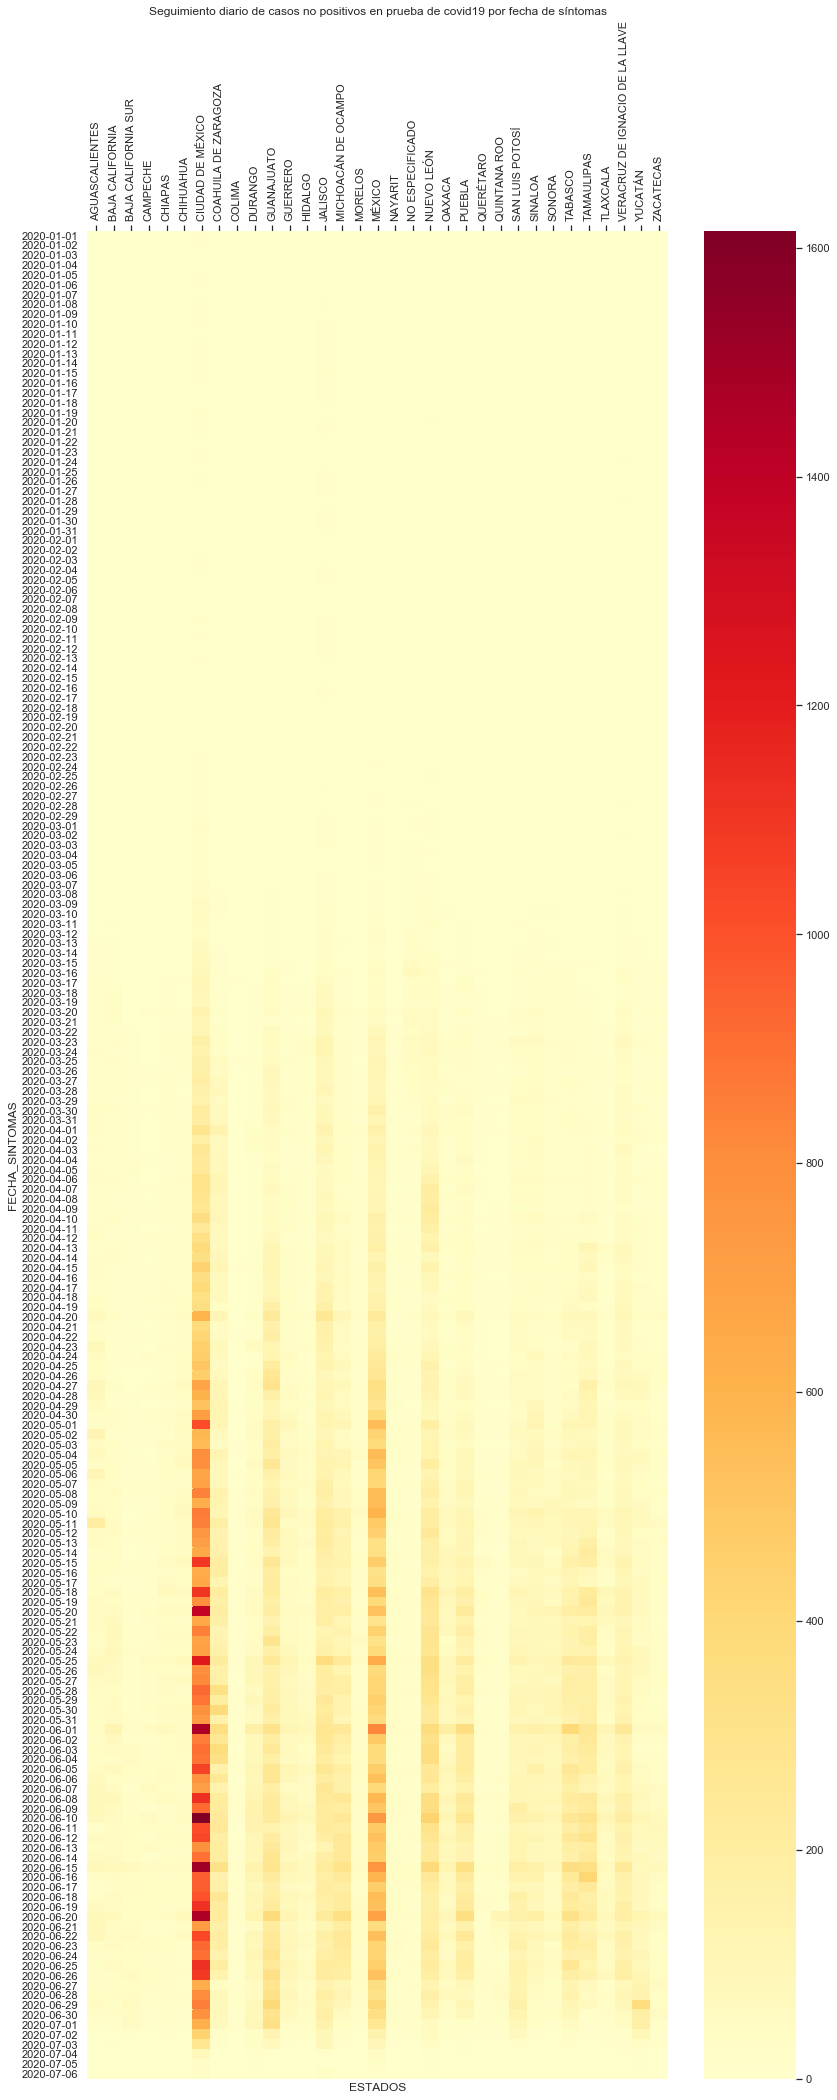

In [22]:
fig1, ax1 = plt.subplots(
        figsize=(13,34))
ax1 = sns.heatmap(entidades_np_pivot, cmap='YlOrRd', xticklabels=True, yticklabels=True)
ax1.set_yticklabels(entidades_np_pivot.index.strftime('%Y-%m-%d'));
ax1.xaxis.set_ticks_position('top');
ax1.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax1.set_title("Seguimiento diario de casos no positivos en prueba de covid19 por fecha de síntomas");

### Defunciones confirmadas por Covid19

In [31]:
decesos_entidades = covid19[(covid19.RESULTADO == 1) & (~covid19.FECHA_DEF.isnull())][['ID_REGISTRO', 'FECHA_DEF', 'ENTIDAD_NAC']].merge(ENTIDADES, left_on='ENTIDAD_NAC', right_on='CLAVE' )
decesos_entidades.drop(['ENTIDAD_NAC', 'CLAVE', 'ABREV'], axis=1, inplace=True)
decesos_entidades.columns = ['ID_REGISTRO','FECHA_DEF','ESTADOS']
decesos_entidades.ESTADOS.astype('category');

In [32]:
decesos_entidades_pivot = pd.pivot_table(decesos_entidades, values='ID_REGISTRO', index=['FECHA_DEF'], 
                        columns=['ESTADOS'], aggfunc='count', fill_value=0).reset_index()
decesos_entidades_pivot.set_index('FECHA_DEF', inplace=True);

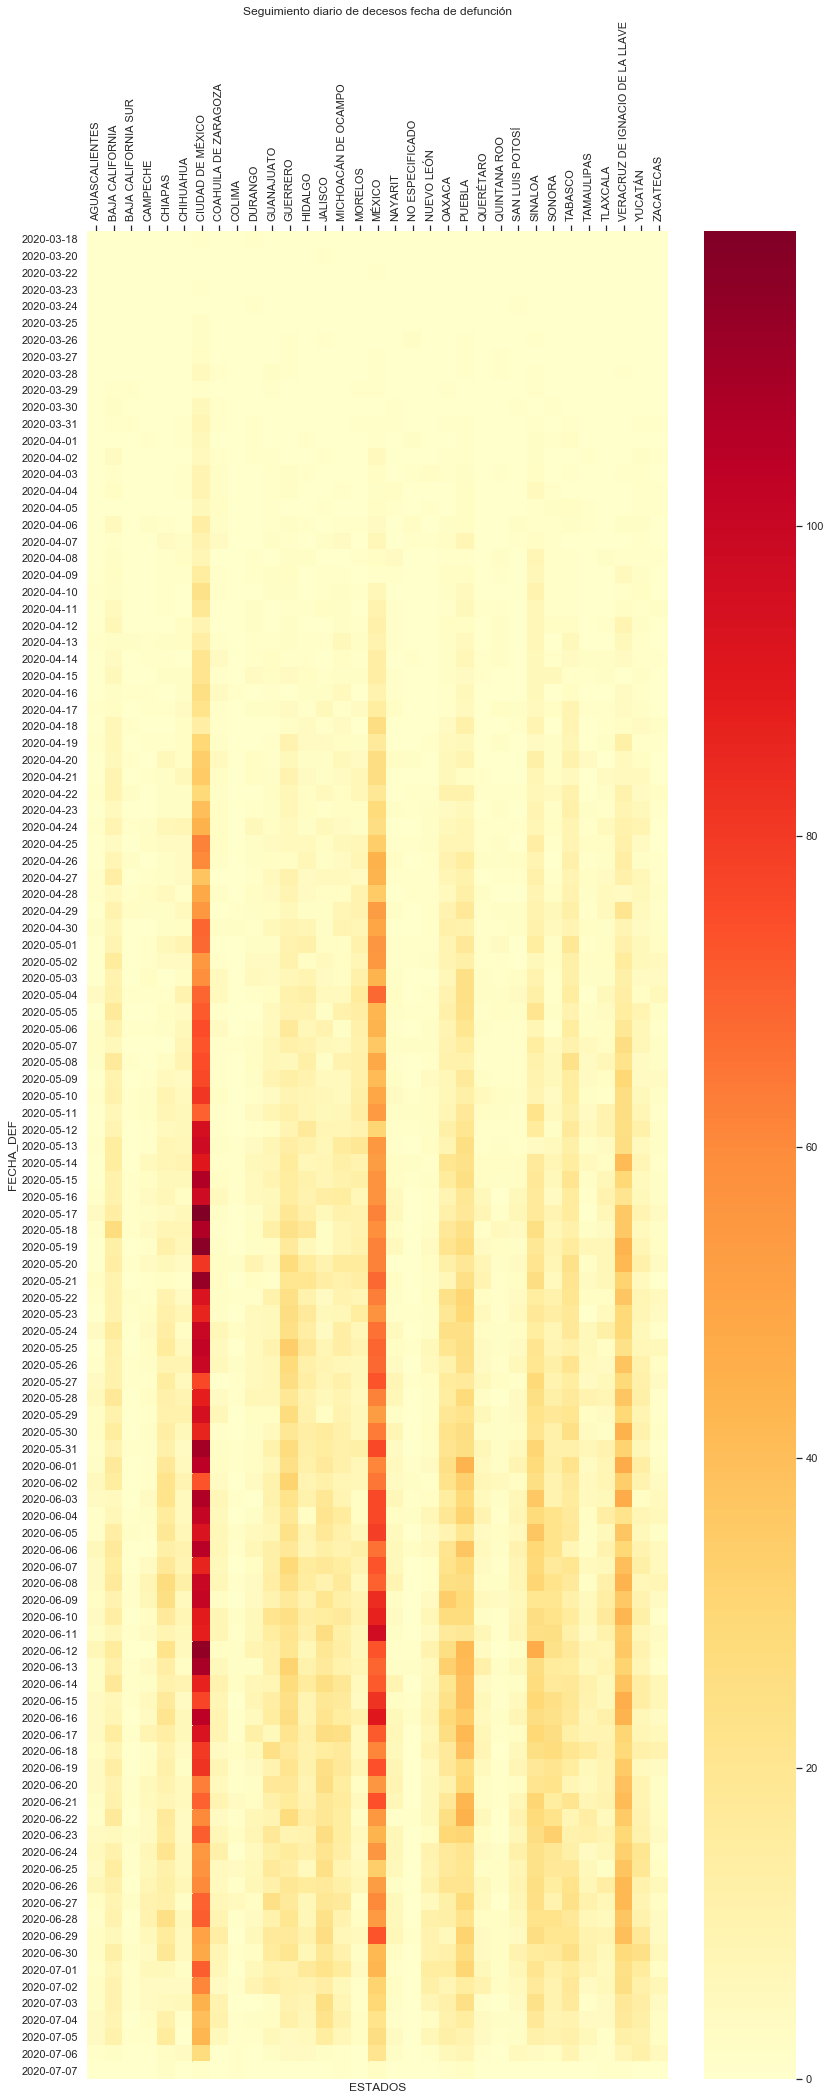

In [33]:
fig2, ax2 = plt.subplots(
        figsize=(13,34))
ax2 = sns.heatmap(decesos_entidades_pivot, cmap='YlOrRd', xticklabels=True, yticklabels=True)
ax2.set_yticklabels(decesos_entidades_pivot.index.strftime('%Y-%m-%d'));
ax2.xaxis.set_ticks_position('top');
ax2.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax2.set_title("Seguimiento diario de decesos fecha de defunción");

In [34]:
# Poblacion no positiva a covid19
COLUMNAS = ['ID_REGISTRO', 'FECHA_SINTOMAS', 'EDAD', 'SEXO', 'ENTIDAD_RES', 'ENTIDAD_NAC', 'FECHA_INGRESO', 
           'TIPO_PACIENTE', 'FECHA_DEF',  'INTUBADO',  'NEUMONIA', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
            'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO',
            'RESULTADO_PREV']
negativos_covid19 = covid19[covid19.RESULTADO == 2][COLUMNAS].merge(SEXO, left_on='SEXO', right_on='CLAVE')
negativos_covid19.drop(['SEXO', 'CLAVE'], axis=1, inplace=True)
negativos_covid19.rename(columns={'DESC':'SEXO'}, inplace=True)
negativos_covid19.SEXO.astype('category');
negativos_covid19 = negativos_covid19.merge(ENTIDADES, left_on='ENTIDAD_NAC', right_on='CLAVE')
negativos_covid19.drop(['ENTIDAD_NAC', 'CLAVE', 'ABREV'], axis=1, inplace=True)
negativos_covid19.rename(columns={'DESC':'ESTADO'}, inplace=True)
negativos_covid19.ESTADO.astype('category');
negativos_covid19 = negativos_covid19.merge(ENTIDADES, left_on='ENTIDAD_RES', right_on='CLAVE')
negativos_covid19.drop(['ENTIDAD_RES', 'CLAVE', 'ABREV'], axis=1, inplace=True)
negativos_covid19.rename(columns={'DESC':'ESTADO_RES'}, inplace=True)
negativos_covid19.ESTADO_RES.astype('category');
negativos_covid19 = negativos_covid19.merge(TIPO_PACIENTE, left_on='TIPO_PACIENTE', right_on='CLAVE')
negativos_covid19.drop(['TIPO_PACIENTE', 'CLAVE'], axis=1, inplace=True)
negativos_covid19.rename(columns={'DESC':'TIPO_PACIENTE'}, inplace=True)
negativos_covid19.TIPO_PACIENTE.astype('category');

In [35]:
# Revisión del resultado previo
negativos_covid19.groupby(['RESULTADO_PREV']).size()

RESULTADO_PREV
1        30
2    321537
3      5589
dtype: int64

SEXO
HOMBRE    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
MUJER     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

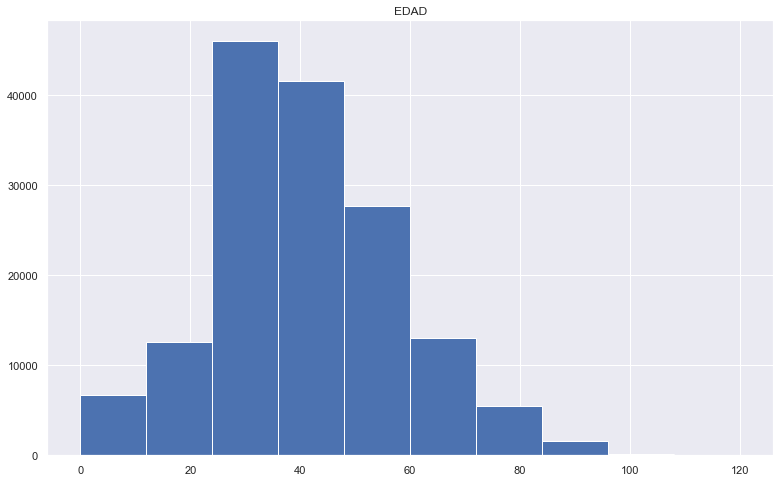

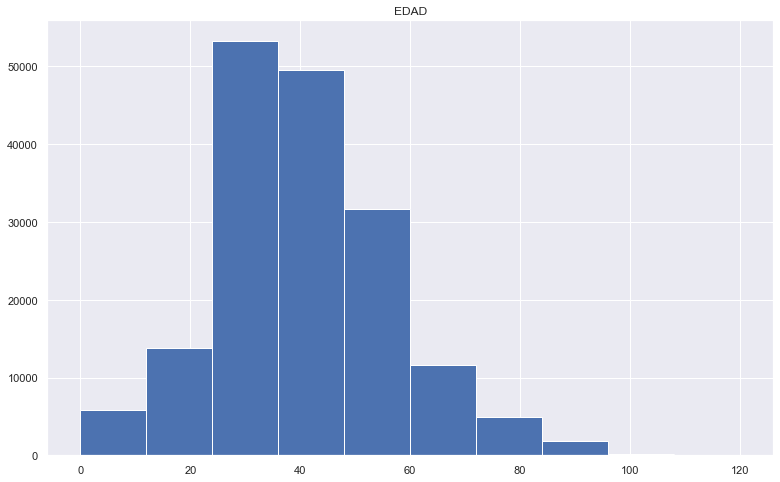

In [42]:
negativos_covid19[['SEXO','EDAD']].groupby(['SEXO']).hist(layout=(1, 1))

SEXO
HOMBRE    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
MUJER     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

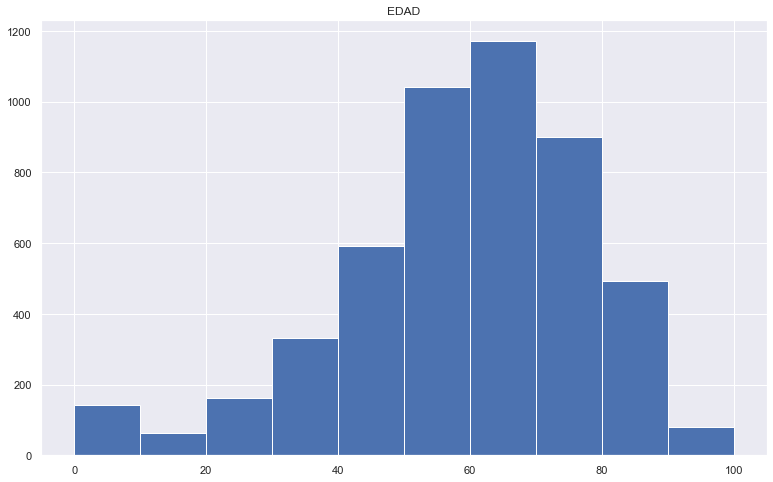

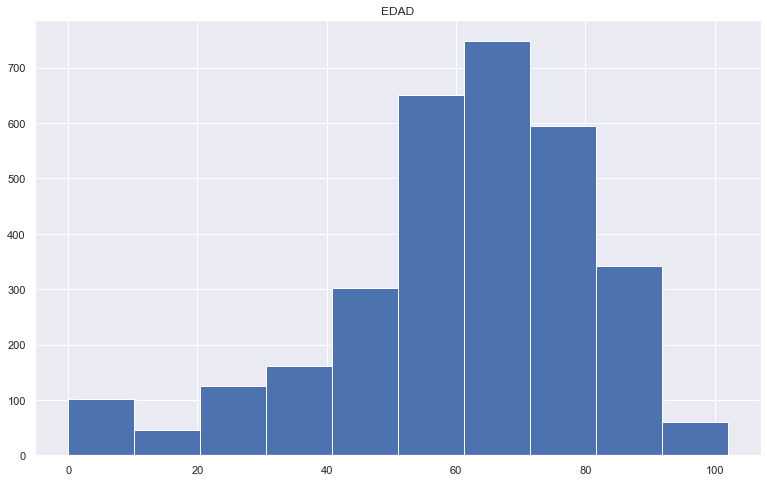

In [37]:
negativos_covid19[~negativos_covid19.FECHA_DEF.isnull()][['SEXO','EDAD']].groupby(['SEXO']).hist(layout=(1, 1))

In [38]:
negativos_covid19[(~negativos_covid19.FECHA_DEF.isnull()) & (negativos_covid19.EDAD<=1)].groupby(['ESTADO','OTRO_CASO']).size()

ESTADO                           OTRO_CASO
AGUASCALIENTES                   99            1
BAJA CALIFORNIA                  1             1
                                 2             4
                                 99            5
BAJA CALIFORNIA SUR              99            1
CAMPECHE                         99            1
CHIAPAS                          2             5
                                 99            3
CHIHUAHUA                        1             1
                                 2             3
                                 99            7
CIUDAD DE MÉXICO                 1             7
                                 2             8
                                 99            5
COAHUILA DE ZARAGOZA             2             4
                                 99            2
DURANGO                          2             1
GUANAJUATO                       2             2
                                 99            2
GUERRERO                  

In [39]:
negativos_covid19[(~negativos_covid19.FECHA_DEF.isnull()) & (negativos_covid19.EDAD<=1)].groupby(['ESTADO']).size()

ESTADO
AGUASCALIENTES                      1
BAJA CALIFORNIA                    10
BAJA CALIFORNIA SUR                 1
CAMPECHE                            1
CHIAPAS                             8
CHIHUAHUA                          11
CIUDAD DE MÉXICO                   20
COAHUILA DE ZARAGOZA                6
DURANGO                             1
GUANAJUATO                          4
GUERRERO                            5
HIDALGO                             1
JALISCO                            15
MICHOACÁN DE OCAMPO                 6
MORELOS                             3
MÉXICO                             13
NAYARIT                             1
NUEVO LEÓN                          2
OAXACA                             11
PUEBLA                              6
QUERÉTARO                           1
QUINTANA ROO                        9
SINALOA                             3
SONORA                              1
TABASCO                             4
TAMAULIPAS                          8
TLAXC

In [ ]:
decesos_totales.shape

In [ ]:
decesos_entidades.FECHA_DEF.min()

In [ ]:
decesos_totales = decesos_entidades.groupby(['FECHA_DEF']).size().reset_index()
decesos_totales.columns = ['FECHA_DEF', 'NUM_DECESOS']

In [ ]:
decesos_totales.set_index('FECHA_DEF')

In [ ]:
plt.plot(decesos_totales.FECHA_DEF, decesos_totales.NUM_DECESOS)

In [ ]:
fig3, ax3 = plt.subplots(
        figsize=(13,34))
ax3 = sns.heatmap(decesos_totales, cmap='YlOrRd', xticklabels=True, yticklabels=True)
ax3.set_yticklabels(decesos_totales.index.strftime('%Y-%m-%d'));
ax3.xaxis.set_ticks_position('top');
ax3.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax3.set_title("Seguimiento diario de decesos fecha de defunción");

### Revisión por fecha confirmación

In [44]:
ruta_cnfmcs = os.path.join(ruta, 'data/historico_confirmaciones.csv')
covid19_confirm = pd.read_csv(ruta_cnfmcs, encoding='latin-1')
covid19_confirm['FECHA_CONFIRMACION'] = pd.to_datetime(covid19_confirm['FECHA_CONFIRMACION'], format='%Y-%m-%d', errors='coerce')
covid19_confirm.head()

,ID_REGISTRO,FECHA_CONFIRMACION
0,09e8dc,2020-04-19
1,0efbaf,2020-04-19
2,0cdb12,2020-04-19
3,038dad,2020-04-19
4,1d8c4e,2020-04-19


In [46]:
covid19_mas = covid19.merge(covid19_confirm, how='left', on='ID_REGISTRO' )
covid19_mas.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,DIAS_FIS,ACTIVO,FECHA_ACTUALIZACION_PREV,RESULTADO_PREV,FECHA_DEF_PREV,TIPO_PACIENTE_PREV,INTUBADO_PREV,UCI_PREV,index,FECHA_CONFIRMACION
0,2020-04-19,1335b7,1,4,16,2,16,16,53.0,1,...,116.0,0.0,2020-04-19,3,NaT,1,97,97,NaN,NaT
1,2020-04-19,099520,1,4,5,1,5,5,18.0,2,...,92.0,0.0,2020-04-19,1,2020-04-05,2,2,2,NaN,NaT
2,2020-04-19,0a271a,2,12,23,1,17,23,5.0,1,...,82.0,0.0,2020-04-19,3,NaT,1,97,97,NaN,NaT
3,2020-04-19,03edf6,2,12,11,2,11,11,27.0,1,...,29.0,0.0,2020-04-19,2,NaT,1,97,97,NaN,NaT
4,2020-04-19,179b46,1,4,9,2,99,9,7.0,2,...,92.0,0.0,2020-04-19,3,NaT,2,2,2,NaN,NaT


In [ ]:
### 

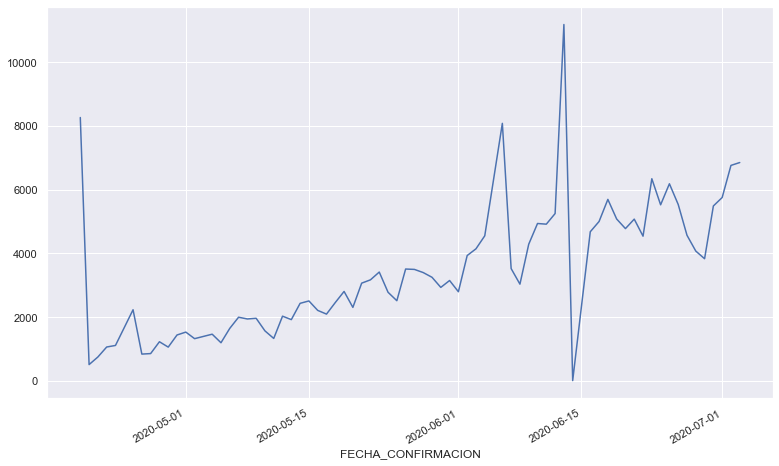

In [47]:
covid19_mas.groupby(['FECHA_CONFIRMACION']).size().plot();

In [ ]:
covid19_mas['DIAS_CONFI_FIS'] = (covid19_mas.FECHA_CONFIRMACION - covid19_mas.FECHA_SINTOMAS).dt.days

In [ ]:
covid19_mas[(covid19_mas.RESULTADO == 1) & (~covid19_mas.DIAS_CONFI_FIS.isnull())].head()